In [2]:
import os

In [4]:
voice_data_path = "./crema"

In [16]:
wav_files = os.listdir(voice_data_path)

emotions = list(map(lambda x: x.split("_")[2], wav_files))

In [73]:
import numpy as np
import soundfile as sf
from scipy.signal import stft, resample

# === Parameters ===
FS = 16000
FRAME_LENGTH = 256
HOP_LENGTH = 128
ROLLOFF_PERCENT = 0.85


def frame_signal(signal, frame_length, hop_length):
    num_frames = 1 + (len(signal) - frame_length) // hop_length
    return np.stack([
        signal[i*hop_length:i*hop_length + frame_length]
        for i in range(num_frames)
    ])


def short_time_energy(frames):
    return np.sum(frames**2, axis=1)


def zero_crossing_rate(frames):
    return np.mean(np.abs(np.sign(frames[:, 1:]) - np.sign(frames[:, :-1])), axis=1) / 2


def crest_factor(frames):
    peak = np.max(np.abs(frames), axis=1)
    rms = np.sqrt(np.mean(frames**2, axis=1)) + 1e-10
    return peak / rms


def envelope_slope(frames):
    envelope = np.abs(frames)
    return np.mean(np.abs(np.diff(envelope, axis=1)), axis=1)


def spectral_features(signal, fs):
    f, _, Zxx = stft(signal, fs=fs, nperseg=FRAME_LENGTH, noverlap=FRAME_LENGTH - HOP_LENGTH, boundary=None)
    mag = np.abs(Zxx) + 1e-10

    # Spectral Centroid
    sum_mag = np.sum(mag, axis=0)
    centroid = np.sum(f[:, None] * mag, axis=0) / sum_mag

    # Spectral Bandwidth
    bandwidth = np.sqrt(np.sum(((f[:, None] - centroid)**2) * mag, axis=0) / sum_mag)

    # Spectral Roll-off
    rolloff = []
    for i in range(mag.shape[1]):
        cumsum = np.cumsum(mag[:, i])
        threshold = ROLLOFF_PERCENT * cumsum[-1]
        idx = np.searchsorted(cumsum, threshold)
        rolloff.append(f[min(idx, len(f)-1)])
    rolloff = np.array(rolloff)

    return centroid, bandwidth, rolloff


def extract_all_features(signal, fs=FS):
    if fs != FS:
        signal = resample(signal, int(len(signal) * FS / fs))
        fs = FS

    frames = frame_signal(signal, FRAME_LENGTH, HOP_LENGTH)

    # Time-domain
    ste = short_time_energy(frames)
    zcr = zero_crossing_rate(frames)
    crest = crest_factor(frames)
    slope = envelope_slope(frames)

    # Spectral
    centroid, bandwidth, rolloff = spectral_features(signal, fs)

    return {
        'ste_mean': np.mean(ste),       
        'zcr_mean': np.mean(zcr),       
        'crest_mean': np.mean(crest),   
        'slope_mean': np.mean(slope),   
        'centroid_mean': np.mean(centroid), 
        'bandwidth_mean': np.mean(bandwidth), 
        'rolloff_mean': np.mean(rolloff)
    }


In [75]:
data = []

for i in range(0, len(wav_files)):
    print(f"Processed: {i} out of {len(wav_files)}")
    signal, sr = sf.read(os.path.join(voice_data_path, wav_files[i]))
    features = extract_all_features(signal, sr)
    emotion = features["emotion"] = emotions[i]
    data.append(features)

Processed: 0 out of 7442
Processed: 1 out of 7442
Processed: 2 out of 7442
Processed: 3 out of 7442
Processed: 4 out of 7442
Processed: 5 out of 7442
Processed: 6 out of 7442
Processed: 7 out of 7442
Processed: 8 out of 7442
Processed: 9 out of 7442
Processed: 10 out of 7442
Processed: 11 out of 7442
Processed: 12 out of 7442
Processed: 13 out of 7442
Processed: 14 out of 7442
Processed: 15 out of 7442
Processed: 16 out of 7442
Processed: 17 out of 7442
Processed: 18 out of 7442
Processed: 19 out of 7442
Processed: 20 out of 7442
Processed: 21 out of 7442
Processed: 22 out of 7442
Processed: 23 out of 7442
Processed: 24 out of 7442
Processed: 25 out of 7442
Processed: 26 out of 7442
Processed: 27 out of 7442
Processed: 28 out of 7442
Processed: 29 out of 7442
Processed: 30 out of 7442
Processed: 31 out of 7442
Processed: 32 out of 7442
Processed: 33 out of 7442
Processed: 34 out of 7442
Processed: 35 out of 7442
Processed: 36 out of 7442
Processed: 37 out of 7442
Processed: 38 out of 7

In [77]:
import pandas as pd

df = pd.DataFrame(data)

In [79]:
df

,ste_mean,zcr_mean,crest_mean,slope_mean,centroid_mean,bandwidth_mean,rolloff_mean,emotion
0,5.517742,0.127613,2.595440,0.026269,1677.773537,1722.462982,3251.439145,ANG
1,0.649824,0.121039,2.526013,0.007236,1604.163750,1730.554807,3261.000000,ANG
2,0.027792,0.079815,2.545654,0.001549,1400.754137,1877.528995,3062.500000,NEU
3,0.047794,0.081816,2.444947,0.001999,1359.275101,1819.530667,2931.537829,NEU
4,0.104889,0.055578,2.414649,0.002263,1130.397653,1709.054317,2547.311453,DIS
...,...,...,...,...,...,...,...,...
7437,2.430992,0.215019,2.644527,0.021045,2313.109925,1987.513985,4294.832155,ANG
7438,1.703938,0.094960,2.508646,0.014116,1480.053753,1738.086237,2913.250000,ANG
7439,1.284603,0.090209,2.561178,0.009092,1470.674303,1818.706780,3220.650338,ANG
7440,0.729233,0.101880,2.507216,0.007708,1479.078638,1811.150183,3032.615291,ANG


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

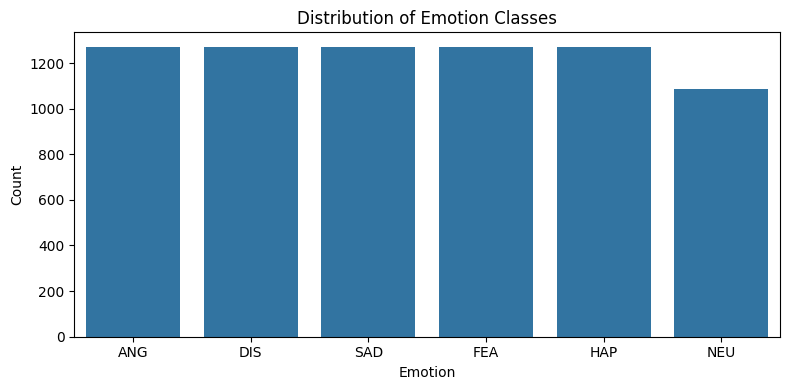

In [83]:
# 1. Distribution of Emotion Classes
plt.figure(figsize=(8, 4))
sns.countplot(x="emotion", data=df, order=df["emotion"].value_counts().index)
plt.title("Distribution of Emotion Classes")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Insights

1. Classes are well distributed enough. Neutral is a bit lower but not significantly

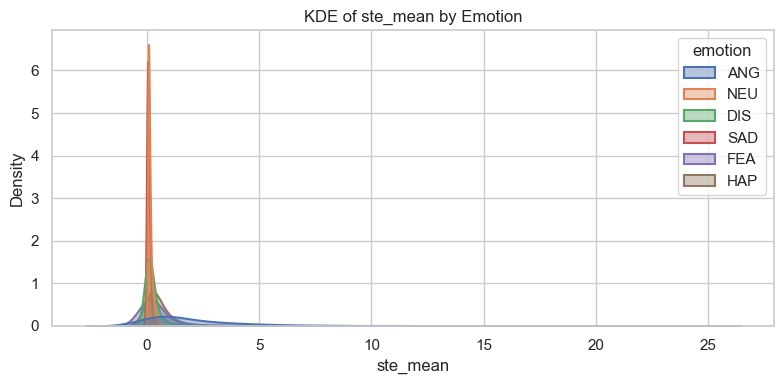

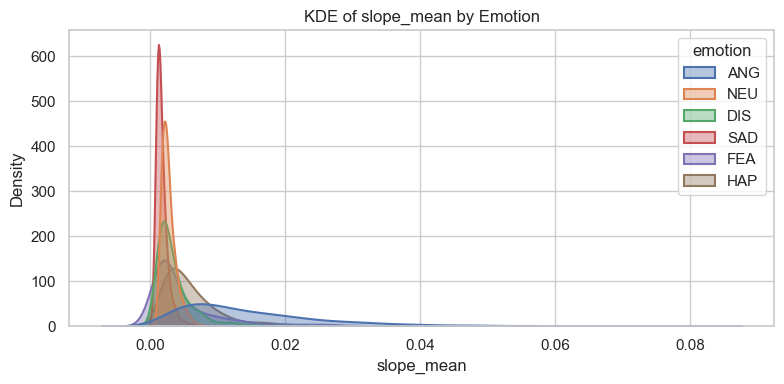

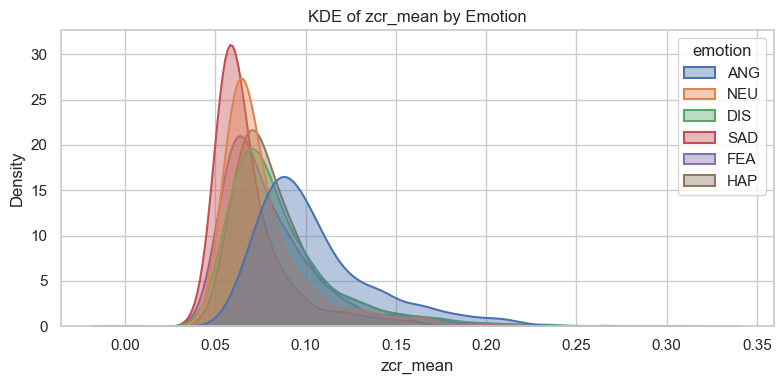

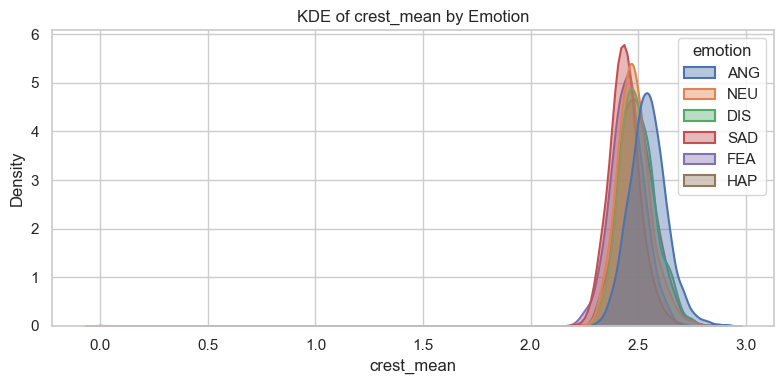

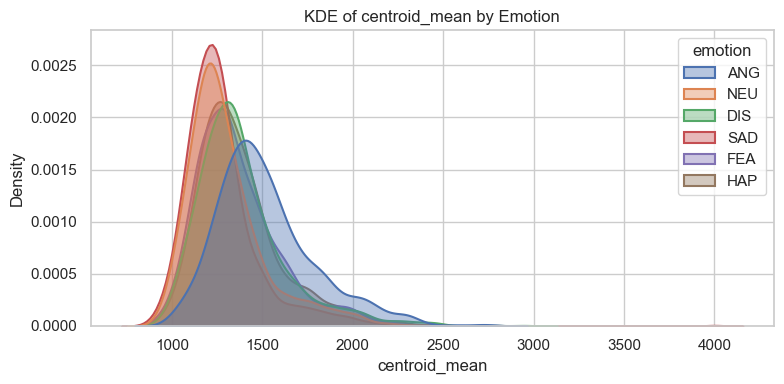

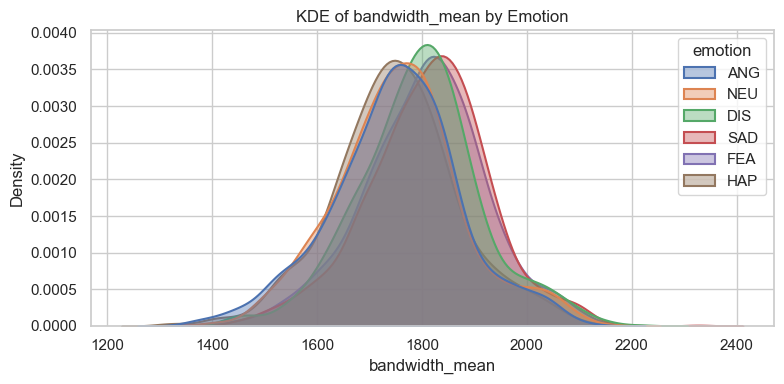

In [102]:
features = ["ste_mean", "slope_mean","zcr_mean", "crest_mean", "centroid_mean","bandwidth_mean"]
# Set up the style
sns.set(style="whitegrid")

# Create one KDE plot per feature
for feature in features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=feature, hue="emotion", fill=True, common_norm=False, alpha=0.4, linewidth=1.5)
    plt.title(f"KDE of {feature} by Emotion")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

## KDE Insights

### Zero-Crossing Rate
**Partial Separation and Distinct Peaks**
Emotions such as Anger (ANG), Fear (FEA), and Happiness (HAP) have distributions shifted slightly to higher values, indicating a higher zero-crossing rate, which often correlates with higher intensity or excitement levels.

Neutral (NEU), Sadness (SAD), and Disgust (DIS) cluster at lower ZCR values, potentially signifying calmer or lower-intensity emotional states.

## Short Term Energy
The ste_mean feature exhibits a broad and flat distribution for anger, indicating high variability in energy. In contrast, other emotions form sharp, narrow peaks near zero, suggesting that ste_mean can effectively capture emotional intensity, particularly for high-energy expressions.

## Envelope Slope
The slope_mean feature shows extremely sharp peaks near zero for most emotions, especially sadness and neutrality, indicating minimal variation. However, anger exhibits a broader and more skewed distribution, suggesting that envelope slope may help capture rapid intensity changes specific to emotionally charged speech.

## Crest Factor
The crest_mean feature shows tightly clustered distributions with strong overlap across all emotions, indicating minimal variation and suggesting it contributes little to distinguishing between emotional states.

## Centroid Bandwidth
The bandwidth_mean feature shows strong overlap and similar distribution shapes across all emotions, indicating limited discriminative power for emotion classification.


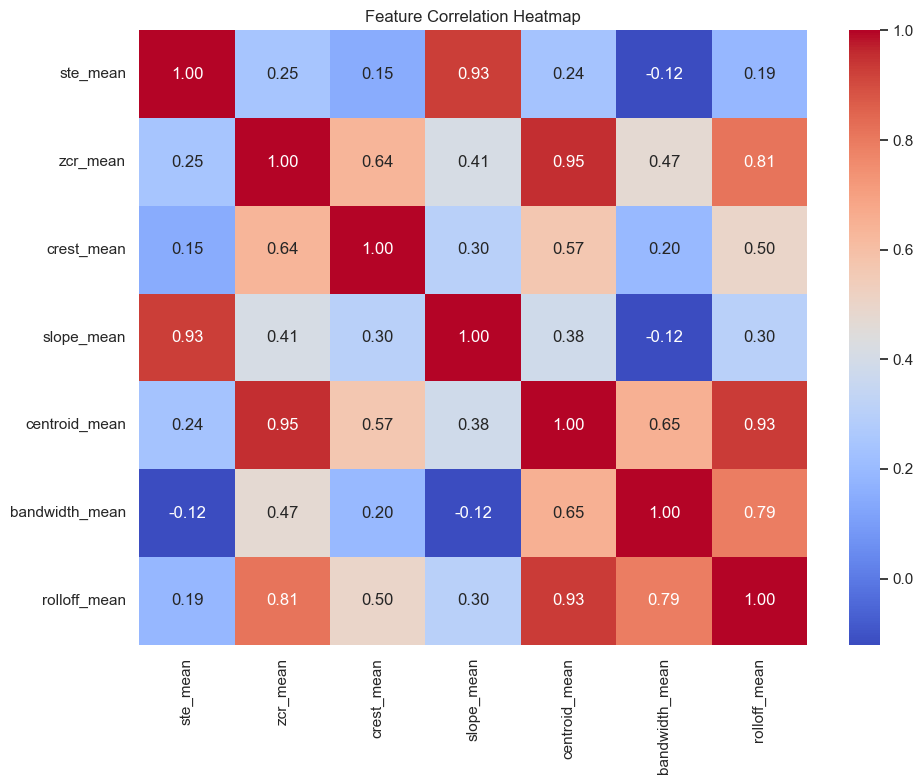

In [106]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df.drop(columns=["emotion"]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

## Insights

1. Very High Correleation between centroid mean and rolloff

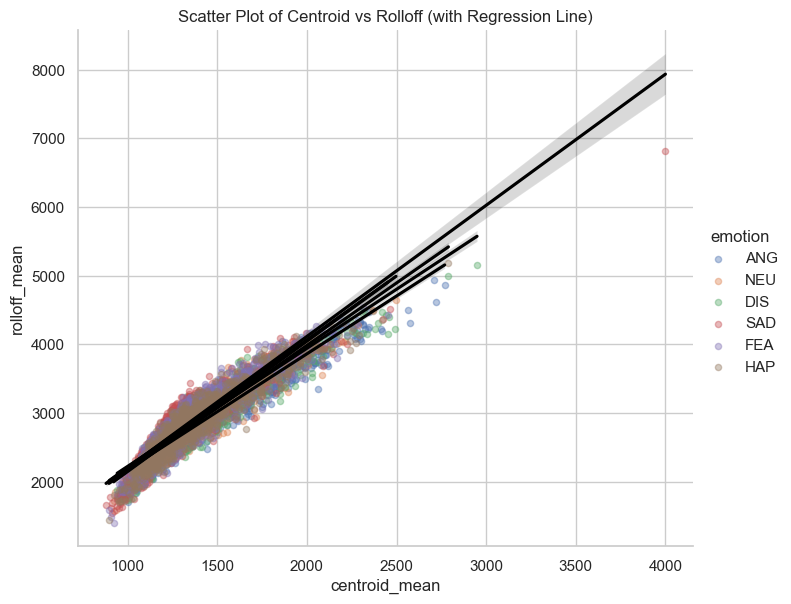

In [109]:
# Visualize high correleation between centroid_mean and rollof
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Basic scatter with regression
sns.lmplot(
    data=df,
    x="centroid_mean",
    y="rolloff_mean",
    hue="emotion",         # Optional: color by emotion
    scatter_kws={"alpha": 0.4, "s": 20},
    line_kws={"color": "black"},
    height=6,
    aspect=1.2
)

plt.title("Scatter Plot of Centroid vs Rolloff (with Regression Line)")
plt.show()


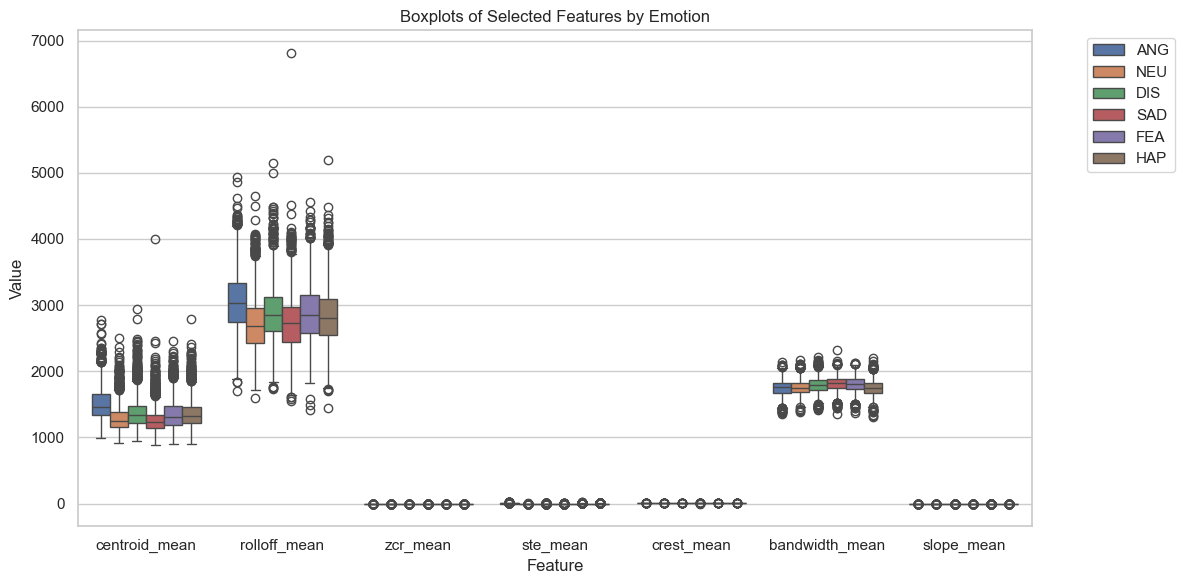

In [111]:
# 3. Boxplots of Features
melted = df.melt(id_vars="emotion", value_vars=[
    "centroid_mean", "rolloff_mean", "zcr_mean", "ste_mean", "crest_mean", "bandwidth_mean", "slope_mean"
], var_name="Feature", value_name="Value")

plt.figure(figsize=(12, 6))
sns.boxplot(data=melted, x="Feature", y="Value", hue="emotion")
plt.title("Boxplots of Selected Features by Emotion")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Centroid mean and rollof mean have very good distinguishing abilities

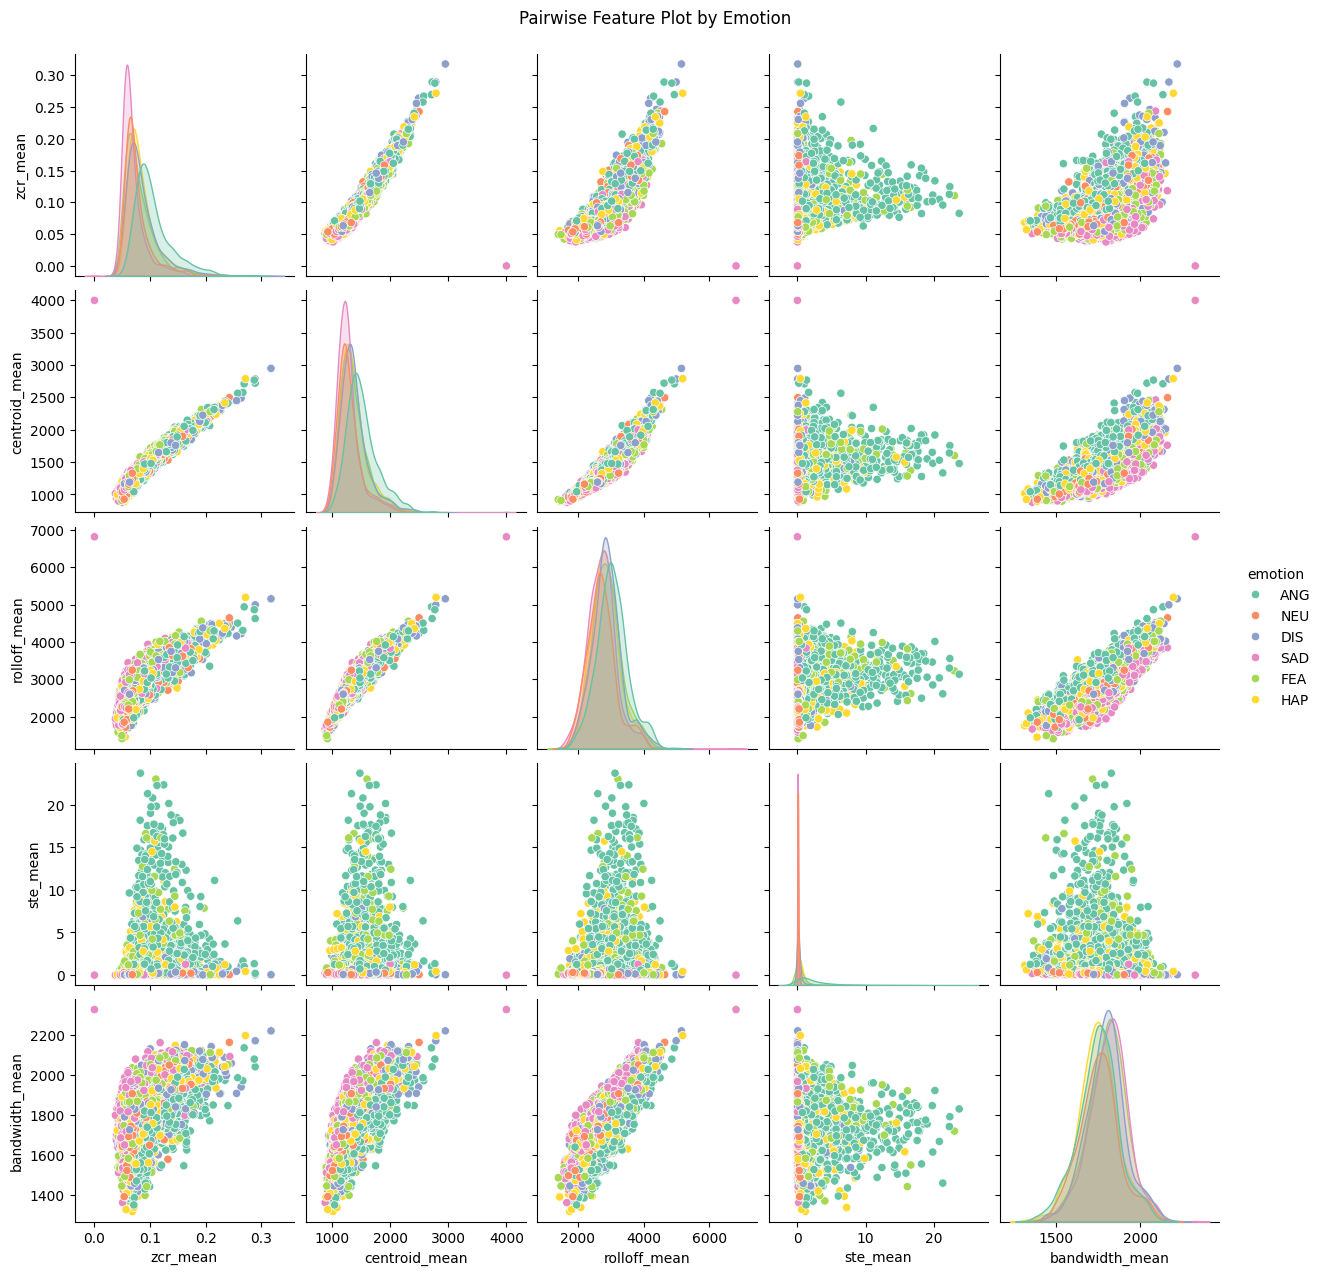

In [85]:
# 2. Pairplot for selected features
selected_features = ["zcr_mean", "centroid_mean", "rolloff_mean", "ste_mean", "bandwidth_mean"]
sns.pairplot(df[selected_features + ["emotion"]], hue="emotion", diag_kind="kde", palette="Set2")
plt.suptitle("Pairwise Feature Plot by Emotion", y=1.02)
plt.show()

Notes:

Looks beautiful hehe, 

In [46]:
# 5. Dimensionality Reduction (PCA + t-SNE)
features = df.drop(columns=["emotion"])
scaled = StandardScaler().fit_transform(features)

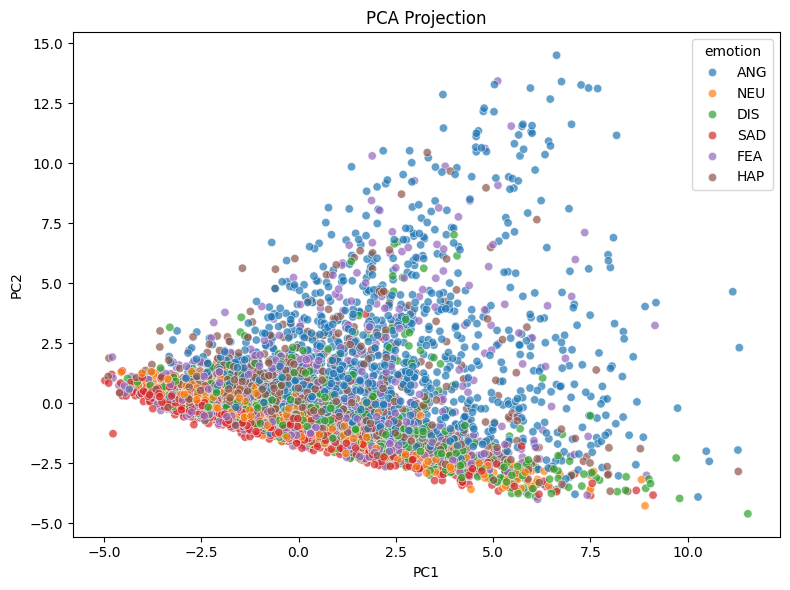

In [48]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["emotion"] = df["emotion"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="emotion", alpha=0.7)
plt.title("PCA Projection")
plt.tight_layout()
plt.show()

Might be difficult to distinguish sadness and neutral

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


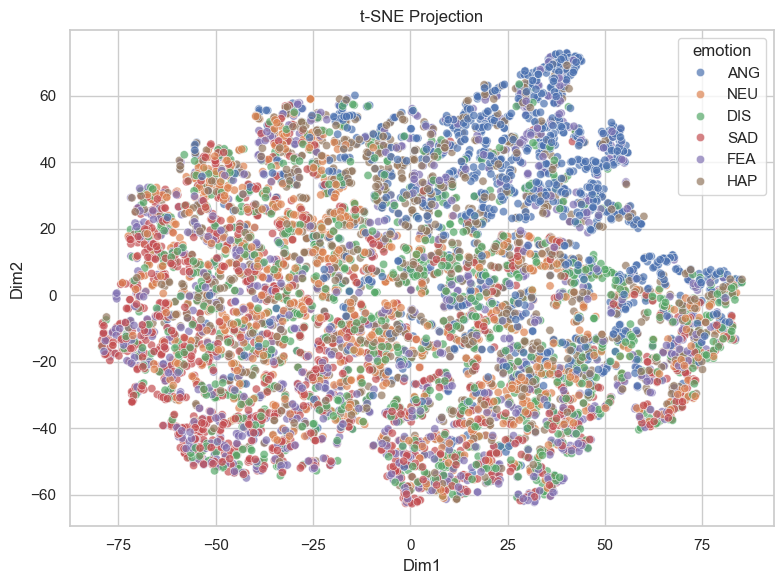

In [124]:


# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(scaled)
tsne_df = pd.DataFrame(tsne_result, columns=["Dim1", "Dim2"])
tsne_df["emotion"] = df["emotion"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="emotion", alpha=0.7)
plt.title("t-SNE Projection")
plt.tight_layout()
plt.show()

Anger is really easy to distinguish

In [67]:
final_colums = ["ste_mean", "slope_mean","zcr_mean", "crest_mean", "centroid_mean", "emotion"]

In [69]:
final_df = df[final_colums]

In [71]:
final_df

,ste_mean,slope_mean,zcr_mean,crest_mean,centroid_mean,emotion
0,5.517742,0.026269,0.127613,2.595440,1677.773537,ANG
1,0.649824,0.007236,0.121039,2.526013,1604.163750,ANG
2,0.027792,0.001549,0.079815,2.545654,1400.754137,NEU
3,0.047794,0.001999,0.081816,2.444947,1359.275101,NEU
4,0.104889,0.002263,0.055578,2.414649,1130.397653,DIS
...,...,...,...,...,...,...
7437,2.430992,0.021045,0.215019,2.644527,2313.109925,ANG
7438,1.703938,0.014116,0.094960,2.508646,1480.053753,ANG
7439,1.284603,0.009092,0.090209,2.561178,1470.674303,ANG
7440,0.729233,0.007708,0.101880,2.507216,1479.078638,ANG
